AI has been shown to be incredibly useful in automation. The problem focused on in this project is an automation of visual tire pressure checks. Tire pressure is crucial for safe driving, enough so that manual checks of trucks' tires are performed at weighing stations. Combined with other checks, this is a lengthy process that slows down shipping times, also raising costs as a result. The goal here is to automate that process.

---

Dataset: https://www.kaggle.com/rhammell/full-vs-flat-tire-images

This dataset is not applicable to the real world. It consists of just 300 images each of flat and full tires, all on identical vehicles in similar lighting conditions and image compositions. Any model trained purely on these images would likely not generalize to other trucks in more complex environments.

As will be demonstrated, the implemented model struggles with this dataset. The model overfits rapidly, a sign of a poor model choice for the problem and/or of a dataset too small to be useful. Because of this, performing an automated hyperparameter search would not be the best choice. It is difficult to tell when a model is overfitting without a more in-depth analysis. Models also converge at varying rates. This adds to the difficulty of quantifying the most successful set of hyperparameter values, as each training instance can have different outcomes.  So, hyperparameters will be chosen manually via hand-tuning. Considerations here include a [qualitative] estimate of typical convergence times, prevalence of overfitting, training times, and dev/test set size, among others.

---

To begin, we load the dataset. Each image will be downscaled to 64x64 pixels (from 240x240 pixels) and converted to grayscale to ease training. Smaller and larger image sizes were tested, but models in those tests struggled to converge at all, with accuracies remaining around 50%. As tires are generally black or dark gray, we won't be losing significant information in reducing the color space. 

Keras' image_dataset_from_directory() function loads data into batches, providing easy batch or mini-batch training setups. A mini-batch size of 10 was chosen via hand-tuning.

A sample of the data will be shown:

Found 600 files belonging to 2 classes.
Dataset split into 60 batches of 10 examples each.


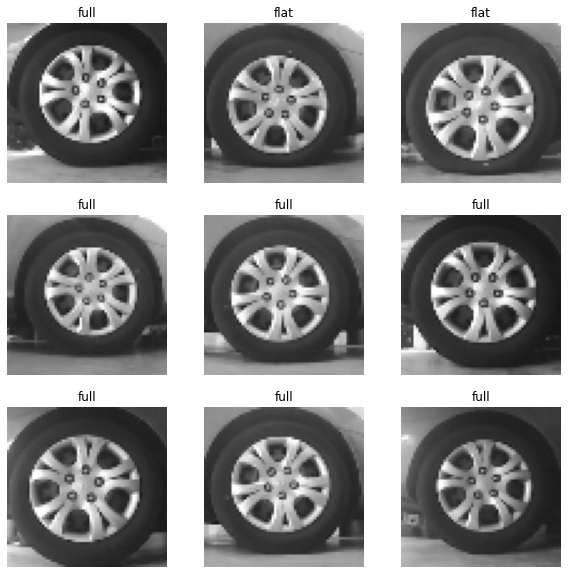

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#source: https://keras.io/api/preprocessing/image/
#helpful reference: https://diegoinacio.github.io/machine-learning-notebooks-page/pages/neural_network_shallow_Keras.html

#some hyperparameters:
imageSize = (64, 64)
imageSizeFlat = imageSize[0]*imageSize[1]
batchSize = 10

#load dataset
tiresDir = "/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW3/tires"
dataset = tf.keras.preprocessing.image_dataset_from_directory(tiresDir, labels='inferred', color_mode='grayscale', image_size=imageSize, batch_size=batchSize, shuffle=True)

#yield some information from dataset
dsSize = dataset.cardinality().numpy()
print("Dataset split into", dsSize, "batches of", batchSize, "examples each.")

#display a sample of the dataset:
def label(numLabel): return "flat" if numLabel == 0 else "full"
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.repeat(images[i].numpy().astype("uint8"), 3, 2))
        plt.title(label(int(labels[i])))
        plt.axis("off")

This project will use the Python Keras API, which itself is written on top of Tensorflow. The library has documentation on its website, which was largely the research source of this project: https://keras.io/api/

I generally find examples of full implementation to be more useful in understanding new frameworks than pure documentation. These two examples of Keras image classifiers were a good reference: https://diegoinacio.github.io/machine-learning-notebooks-page/pages/neural_network_shallow_Keras.html and https://keras.io/examples/vision/image_classification_from_scratch/ 

Both references were used to build an understanding of how Keras works (especially Model and Dataset classes), and as sources for research in the Keras API. 

Keras is an industry standard in deep learning. It's well known for its ease of use, wide featureset, and cross-compatibility with other libraries. Using a library like this allows for quick and easy construction of efficient models, saving build time and allowing for rapid prototyping/tweaking. The library reduces the task of building a training complex models to a few simple functions, handling all computations internally. This includes forward and backward propagation.

---

When data is too homogenous, the risk of overfitting increases, and generalizability may be hurt. To counter this, artifical variations can be introduced into the dataset that simulate natural ones. This shouldn't be necessary here. As can be seen in the sample above, examples have enough variation in composition and lighting that dataset homogeneity shouldn't be an issue.

---

Let's process the data to further ease training. We'll standardize the color data to be a float between 0 and 1 (rather than 0-255), and reshape each image to be a 1D tensor of numbers (instead of 64x64x1, just 4096). To do this, we build a Keras Sequential model with layers to perform these operations, and use it to form a new standardizedDataset from the old dataset.

In [28]:
w = imageSize[0]
h = imageSize[1]

standardizer = tf.keras.Sequential([
    tf.keras.layers.Reshape((imageSizeFlat,), input_shape=(w,h,1,)), #flattens images
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255) #standardization
])

standardizedDataset = dataset.map(lambda x, y: (standardizer(x), y)) #map old dataset to new using the standardizer

With pre-processing and exploratory data analysis complete, we split the processed data into train/dev/test sets. This dataset is small, so a standard 70/20/10 split for smaller datasets was selected. 

In [29]:
dsSplit = [0.7, 0.2, 0.1] #train/dev/test split ratios

#split the data
trainSize = int(dsSplit[0] * dsSize)
devSize = int(dsSplit[1] * dsSize)
trainSet = standardizedDataset.take(trainSize)    
devSet = standardizedDataset.skip(trainSize).take(devSize)
testSet = standardizedDataset.skip(trainSize).skip(devSize)

#print some information about the split
print("At", batchSize, "examples per batch:")
print(">Train set example count:", trainSet.cardinality().numpy()*batchSize)
print(">Dev set example count:  ", devSet.cardinality().numpy()*batchSize)
print(">Test set example count: ", testSet.cardinality().numpy()*batchSize)

At 10 examples per batch:
>Train set example count: 420
>Dev set example count:   120
>Test set example count:  60


Now we construct the model. This will be a 2-layer NN with a feed-forward architecture, consisting of one hidden layer and one output layer (as well as an input layer). 

The hidden layer consists of 30 neurons, the size of which was selected via hand-tuning, with a ReLU activation. ReLU was chosen as for its ease of training and good handling of vanishing/exploding gradients. Other activation functions struggled with making progress past 50% accuracy, essentially a guess.

The output layer consists of a single neuron with a sigmoid activation function. This is a binary classification problem. A single neuron's sigmoid output can be rounded to provide a binary class -- 0 or 1.

For now, we will use no optimization algorithms.

In [30]:
#!pip3 install keras-visualizer
from keras_visualizer import visualizer

#model construction hyperparameters
hiddenLayerSize = 30
hiddenLayerActivation = 'relu'
outputLayerActivation = 'sigmoid'

#build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(imageSize[0]*imageSize[1]),
    tf.keras.layers.Dense(hiddenLayerSize, activation=hiddenLayerActivation, name="hidden"),
    tf.keras.layers.Dense(1, activation=outputLayerActivation, name="output")
])

# compile model
model.compile(
    loss='mean_squared_error',
    metrics=['accuracy']
)

visualizer(model, format='png', view=True) #for some reason, viewing the png doesn't work in this notebook. it's available as a saved file, graph.png

With everything ready, we train the model using mini-batch gradient descent. 10 models with identical parameters will be trained on the same data, with the accuracies of each throuhgout training shown in a graph below.

==> Training accuracy exceeded 95%, early stopping initiated at epoch 12.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 8.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 9.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 11.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 10.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 11.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 10.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 7.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 11.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 9.


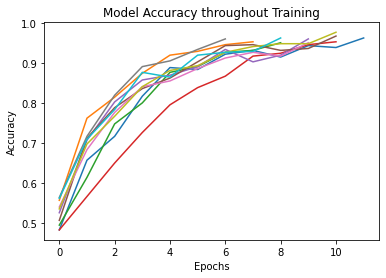

In [31]:
epochs = 20

model.save_weights("random weights")

#runs the model a single time, returning a list of accuracy at the end of each epoch
def runModel(): 
  accLog = []
  for e in range(epochs):
    model.fit(trainSet, epochs=1, validation_data=devSet,)
    accLog += [ex for ex in model.history.history['accuracy']]
    if(accLog[len(accLog)-1] >= 0.94999999): 
      print("\n==> Training accuracy exceeded 95%%, early stopping initiated at epoch %d.\n" % (e+1))
      break #implementation of early stopping

  return accLog

#runs the model many times, returning lists of accuracy at the end of each epoch in each run
def runModelNumerous(runCount):
  accLogs = []
  for i in range(runCount):
    accLog = []
    model.load_weights("random weights") #reset the weights

    #train the model
    for e in range(epochs):
      model.fit(trainSet, epochs=1, validation_data=devSet, verbose=0)
      accLog += [ex for ex in model.history.history['accuracy']]
      if(accLog[len(accLog)-1] >= 0.94999998): 
        print("==> Training accuracy exceeded 95%%, early stopping initiated at epoch %d." % (e+1))
        break #implementation of early stopping
    accLogs.append(accLog)
    if(e == epochs-1):
      print("==> Epoch limit of %d reached, training halted." % (epochs))
  return accLogs

#run 10 models
logs = runModelNumerous(10)

#graph accuracies
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy throughout Training")
for i in range(len(logs)):
  plt.plot(logs[i]) #a legend is unnecessary here, which specific run a color represents doesn't matter
plt.show()

There's some variability in performance here. Though all models converged, they did at different rates, and all did quickly as well, taking anywhere from 7-12 epochs to reach 95% accuracy. Let's test the model using the test set:

In [32]:
model.evaluate(testSet)

6/6 [==============================] - 1s 2ms/step - loss: 0.0245 - accuracy: 0.9667


[0.02447604015469551, 0.9666666388511658]

On the test set, the last-trained model of the 10 achieved a 96.67% accuracy. That's a very high result, and training converged quickly. The model is likely overfitting. An optimization algorithm would only worsen this effect. This will be demonstrated by training another 10 models, identical in all ways except that the new ones will use the ADAM optimizer:

==> Training accuracy exceeded 95%, early stopping initiated at epoch 3.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 4.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 3.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 4.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 4.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 3.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 3.
==> Training accuracy exceeded 95%, early stopping initiated at epoch 4.
==> Epoch limit of 20 reached, training halted.
==> Epoch limit of 20 reached, training halted.


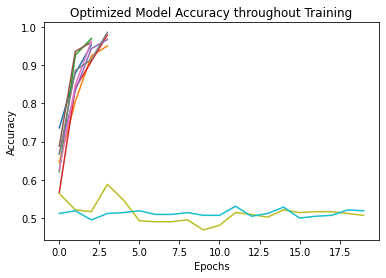

In [33]:
model.load_weights("random weights")

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy']
)

logs = runModelNumerous(10)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Optimized Model Accuracy throughout Training")
for i in range(len(logs)):
  plt.plot(logs[i])
plt.show()

Yikes. Some models converged very rapidly, some didn't even after 20 epochs. Optimizers are not appropriate when the model is converging too rapidly without them already.

---

Ultimately, this dataset is too small to really be useful. On top of that, a convolutional neural network architecture is likely better suited for the problem: it would be able to pick up features that indicate a full or flat tire better than a generic neural network like this one. 